In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score 
from sklearn.pipeline import Pipeline

In [3]:
#The goal is to create a model that identifies fraud transactions
#We have data about the user, card, and transaction
#Since we want to identify each transaction as fraud, we'll join card and user into to the transaction table

In [4]:
#Lets get user data

In [5]:
users = pd.read_csv('credit_card_users_de.csv')

In [6]:
#We know the user corresponds with the index of the row
#So let's pull this in as id

In [7]:
users['id'] = users.index

In [8]:
users.head()

,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,id
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5,0
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5,1
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5,2
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4,3
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1,4


In [9]:
#Let's get the info for the cards

In [10]:
cards = pd.read_csv('sd254_cards_de.csv')

In [11]:
cards.head()

,User,CARD INDEX,Card Brand,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,0,1,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,0,2,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,0,3,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,0,4,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [12]:
cards[cards['CARD INDEX'] == 0].head(10)

,User,CARD INDEX,Card Brand,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
5,1,0,Visa,Credit,4404898874682993,09/2003,736,YES,1,$27500,09/2003,2012,No
10,2,0,Mastercard,Debit,5495199163052054,03/2022,677,YES,2,$31599,10/2009,2009,No
15,3,0,Visa,Credit,4017261190134817,05/2015,877,YES,2,$98100,01/2011,2011,No
19,4,0,Mastercard,Debit,5905027855347659,01/2022,886,YES,1,$34900,12/1999,2012,No
20,5,0,Visa,Credit,4099623033306950,09/2021,74,YES,2,$9900,01/2002,2019,No
23,6,0,Mastercard,Debit,5202477865497336,04/2022,861,YES,1,$29964,06/2005,2014,No
26,7,0,Visa,Debit,4595831603224644,05/2023,689,NO,2,$17480,01/2020,2020,No
27,8,0,Mastercard,Debit,5341049613275152,09/2021,396,YES,2,$26546,11/2009,2009,No
32,9,0,Mastercard,Debit,5294178176133532,07/2024,265,YES,2,$9496,07/2009,2012,No


In [13]:
#Lets make yes/no columns 1/0 columns

In [14]:
cards['Card on Dark Web'] = np.where(cards['Card on Dark Web'] == 'Yes', 1, 0)

In [15]:
cards['Has Chip'] = np.where(cards['Has Chip'] == 'YES', 1, 0)

In [16]:
#Lets also make category columns dummy columns

In [17]:
cards_cats = cards[['Card Brand', 'Card Type']].copy()

In [18]:
cards_cats = pd.get_dummies(cards_cats)

In [19]:
cards_cats.head()

,Card Brand_Amex,Card Brand_Discover,Card Brand_Mastercard,Card Brand_Visa,Card Type_Credit,Card Type_Debit,Card Type_Debit (Prepaid)
0,0,0,0,1,0,1,0
1,0,0,0,1,0,1,0
2,0,0,0,1,0,1,0
3,0,0,0,1,1,0,0
4,0,0,1,0,0,0,1


In [20]:
cards = cards.drop(['Card Brand', 'Card Type'], axis=1)

In [21]:
cards = pd.concat([cards, cards_cats], axis=1)

In [22]:
cards['Credit Limit'] = cards['Credit Limit'].apply(lambda x: x.replace('$', ''))

In [23]:
cards.head()

,User,CARD INDEX,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web,Card Brand_Amex,Card Brand_Discover,Card Brand_Mastercard,Card Brand_Visa,Card Type_Credit,Card Type_Debit,Card Type_Debit (Prepaid)
0,0,0,4344676511950444,12/2022,623,1,2,24295,09/2002,2008,0,0,0,0,1,0,1,0
1,0,1,4956965974959986,12/2020,393,1,2,21968,04/2014,2014,0,0,0,0,1,0,1,0
2,0,2,4582313478255491,02/2024,719,1,2,46414,07/2003,2004,0,0,0,0,1,0,1,0
3,0,3,4879494103069057,08/2024,693,0,1,12400,01/2003,2012,0,0,0,0,1,1,0,0
4,0,4,5722874738736011,03/2009,75,1,1,28,09/2008,2009,0,0,0,1,0,0,0,1


In [24]:
#Curious how many cards ended up on the dark web

In [25]:
cards['Card on Dark Web'].value_counts()

0    6146
Name: Card on Dark Web, dtype: int64

In [26]:
#No cards have ended up on the dark web, so we won't use that column for now

In [27]:
#Let's pull the transactional data

In [28]:
transactions = pd.read_csv('credit_card_transaction_data_de_1.csv')

In [29]:
transactions = transactions.drop('__index_level_0__', axis=1)

In [30]:
transactions.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2016,1,3,10:48,$66.48,Chip Transaction,-3345936507911876459,La Verne,CA,91750.0,7538.0,NaN,No
1,0,0,2016,1,4,06:43,$40.02,Chip Transaction,-34551508091458520,La Verne,CA,91750.0,5912.0,NaN,No
2,0,0,2016,1,7,09:30,$54.11,Chip Transaction,4055257078481058705,La Verne,CA,91750.0,7538.0,NaN,No
3,0,0,2016,1,7,16:03,$89.48,Chip Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651.0,NaN,No
4,0,0,2016,1,10,06:38,$29.15,Chip Transaction,-5475680618560174533,Monterey Park,CA,91755.0,5942.0,NaN,No


In [31]:
transactions['Is Fraud?'] = transactions['Is Fraud?'].astype('str')

In [32]:
transactions[transactions['Is Fraud?'] == 'nan'].head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
4167211,1221,3,2016,10,30,21:29,$58.68,Chip Transaction,288419336064101772,NaN,NaN,NaN,NaN,NaN,nan


In [33]:
#Let's remove this for now

In [34]:
transactions = transactions.drop(transactions[transactions['Is Fraud?'] == 'nan'].index)

In [35]:
transactions = transactions.reset_index(drop=True)

In [36]:
transactions.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2016,1,3,10:48,$66.48,Chip Transaction,-3345936507911876459,La Verne,CA,91750.0,7538.0,NaN,No
1,0,0,2016,1,4,06:43,$40.02,Chip Transaction,-34551508091458520,La Verne,CA,91750.0,5912.0,NaN,No
2,0,0,2016,1,7,09:30,$54.11,Chip Transaction,4055257078481058705,La Verne,CA,91750.0,7538.0,NaN,No
3,0,0,2016,1,7,16:03,$89.48,Chip Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651.0,NaN,No
4,0,0,2016,1,10,06:38,$29.15,Chip Transaction,-5475680618560174533,Monterey Park,CA,91755.0,5942.0,NaN,No


In [37]:
#Less than 1% of the data is fraud
#This level of class imbalance means we'll have to consider some data re-sampling
#This way the two groups are close in the number of observations

In [38]:
#Let's clean up the error column

In [39]:
transactions['Errors?'] = transactions['Errors?'].astype('str')

In [40]:
transactions['Errors?'].value_counts(dropna=False)

nan                                      4100666
Insufficient Balance                       40704
Bad PIN                                     9978
Technical Glitch                            8317
Bad Card Number                             2703
Bad Expiration                              2112
Bad CVV                                     2082
Bad Zipcode                                  361
Bad PIN,Insufficient Balance                  85
Insufficient Balance,Technical Glitch         68
Bad PIN,Technical Glitch                      26
Bad Card Number,Insufficient Balance          23
Bad CVV,Insufficient Balance                  18
Bad Card Number,Bad CVV                       15
Bad Card Number,Bad Expiration                14
Bad Expiration,Insufficient Balance           12
Bad Expiration,Bad CVV                        12
Bad Expiration,Technical Glitch                5
Bad Zipcode,Insufficient Balance               3
Bad CVV,Technical Glitch                       3
Bad Card Number,Tech

In [41]:
#There are various errors, which will be cool to see
#But I also want to simplify to see whether an error at all can indicate fraud

In [42]:
transactions['is_error'] = np.where(transactions['Errors?'] == 'nan', 0, 1)

# Exploratory Data Analysis

In [43]:
#Lets explore a few different areas that could be interesting

In [44]:
#Whether certain attributes of your card contribute to having card on dark web (correlation matrix just dark web)

In [45]:
X = cards.drop(['User', 'CARD INDEX', 'Card Number', 'Expires', 'CVV',
                       'Acct Open Date', 'Year PIN last Changed', 'Card on Dark Web'], axis=1)

In [46]:
X = X.apply(pd.to_numeric)

<Axes: >

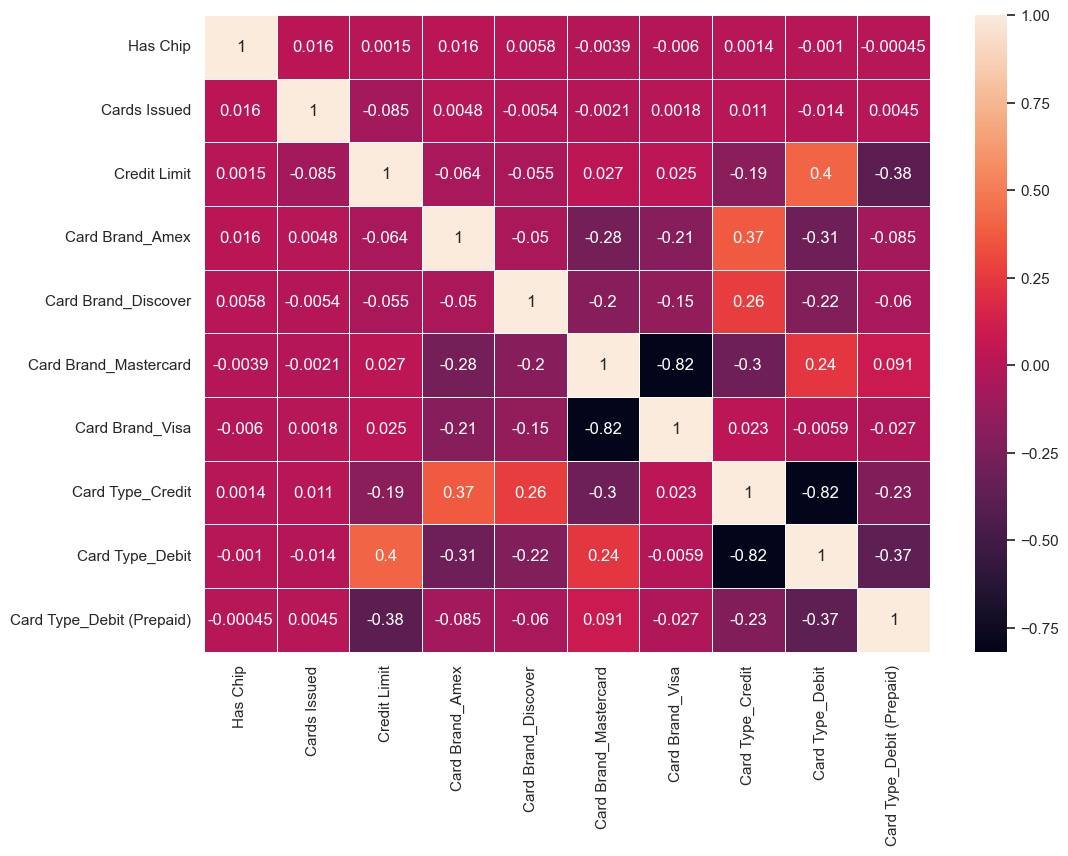

In [47]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.heatmap(X.corr(), annot=True, linewidth=.5)

In [48]:
#Credit limit/Type_Debit and Type_Credit/Amex have the higest correlations
#The big negative correlations are between different card brands 
#Which makes sense, as these brands are mutually exclusive

In [49]:
#Looking at transactions, let's see if there's a correlation with certain states and is_fraud

# Modeling Fraudulent Transactions

In [50]:
#We want to identify fraudulent transactions, but we need to avoid black box models like Random Forest
#Banks have compliance protocols, meaning they have to explain why they identified something as fraud
#Using black box models makes it hard to do that
#We'll start with a Logistic Regression model, then evaluate from there

In [51]:
#Let convert the fraud column to 0/1

In [52]:
transactions['Is Fraud?'] = np.where(transactions['Is Fraud?'] == 'Yes', 1, 0)

In [53]:
#Curious how much of the data is fraud vs not

In [54]:
transactions['Is Fraud?'].value_counts(normalize=True)

0    0.998785
1    0.001215
Name: Is Fraud?, dtype: float64

In [55]:
#So few of the data is fraud, so we will need to account this class imbalance
#We can either use metrics like precision/recall/F1 to assess model quality
#Or we can train the model on a sample the non-fraud data equal to the number of fraud transactions

In [56]:
#Let's try using precision/recall/F1 to assess model quality
#Based on this, we can try to resample

In [57]:
#Let's prep the data for the model

In [58]:
transactions = transactions.merge(cards, left_on=['User', 'Card'], right_on=['User', 'CARD INDEX'], how='left')

In [59]:
transactions = transactions.merge(users, left_on='User', right_on='id', how='left')

In [60]:
transactions.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,id
0,0,0,2016,1,3,10:48,$66.48,Chip Transaction,-3345936507911876459,La Verne,...,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5,0
1,0,0,2016,1,4,06:43,$40.02,Chip Transaction,-34551508091458520,La Verne,...,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5,0
2,0,0,2016,1,7,09:30,$54.11,Chip Transaction,4055257078481058705,La Verne,...,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5,0
3,0,0,2016,1,7,16:03,$89.48,Chip Transaction,3414527459579106770,Monterey Park,...,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5,0
4,0,0,2016,1,10,06:38,$29.15,Chip Transaction,-5475680618560174533,Monterey Park,...,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5,0


In [61]:
#Lets see all the potential data points we have to work with

In [62]:
transactions.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?', 'is_error', 'CARD INDEX', 'Card Number',
       'Expires', 'CVV', 'Has Chip', 'Cards Issued', 'Credit Limit',
       'Acct Open Date', 'Year PIN last Changed', 'Card on Dark Web',
       'Card Brand_Amex', 'Card Brand_Discover', 'Card Brand_Mastercard',
       'Card Brand_Visa', 'Card Type_Credit', 'Card Type_Debit',
       'Card Type_Debit (Prepaid)', 'Person', 'Current Age', 'Retirement Age',
       'Birth Year', 'Birth Month', 'Gender', 'Address', 'Apartment', 'City',
       'State', 'Zipcode', 'Latitude', 'Longitude',
       'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt',
       'FICO Score', 'Num Credit Cards', 'id'],
      dtype='object')

In [63]:
#Let's make dummies for the following variables
#Month
#Day
#Use Chip
#Errors

In [64]:
transactions['Month'] = transactions['Month'].astype('str')
transactions['Day'] = transactions['Day'].astype('str')

In [65]:
transactions_dummies = pd.get_dummies(transactions[['Month', 'Day', 'Use Chip', 'Errors?']])

In [66]:
#We don't need this b/c if 1, the it's not an error, which is captured by is_error

transactions_dummies = transactions_dummies.drop('Errors?_nan', axis=1)

In [67]:
transactions = pd.concat([transactions, transactions_dummies])

In [68]:
#Create binaries for following variables
#Gender
#Merchant State  == State
#Transaction zip == person zip

In [69]:
transactions['Gender'] = np.where(transactions['Gender'] == 'Female', 0, 1)

In [70]:
transactions['state_match'] = np.where(transactions['Merchant State'] == transactions['State'], 1, 0)

In [71]:
transactions['zip_match'] = np.where(transactions['Zip'] == transactions['Zipcode'], 1, 0)

In [72]:
transactions.iloc[:5, :]

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,"Errors?_Bad PIN,Insufficient Balance","Errors?_Bad PIN,Technical Glitch",Errors?_Bad Zipcode,"Errors?_Bad Zipcode,Insufficient Balance","Errors?_Bad Zipcode,Technical Glitch",Errors?_Insufficient Balance,"Errors?_Insufficient Balance,Technical Glitch",Errors?_Technical Glitch,state_match,zip_match
0,0.0,0.0,2016.0,1,3,10:48,$66.48,Chip Transaction,-3.345937e+18,La Verne,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,0.0,0.0,2016.0,1,4,06:43,$40.02,Chip Transaction,-3.455151e+16,La Verne,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
2,0.0,0.0,2016.0,1,7,09:30,$54.11,Chip Transaction,4.055257e+18,La Verne,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
3,0.0,0.0,2016.0,1,7,16:03,$89.48,Chip Transaction,3.414527e+18,Monterey Park,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,0.0,0.0,2016.0,1,10,06:38,$29.15,Chip Transaction,-5.475681e+18,Monterey Park,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [73]:
transactions[transactions['Is Fraud?'].isna()].head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,"Errors?_Bad PIN,Insufficient Balance","Errors?_Bad PIN,Technical Glitch",Errors?_Bad Zipcode,"Errors?_Bad Zipcode,Insufficient Balance","Errors?_Bad Zipcode,Technical Glitch",Errors?_Insufficient Balance,"Errors?_Insufficient Balance,Technical Glitch",Errors?_Technical Glitch,state_match,zip_match
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [74]:
transactions = transactions.dropna(subset='Is Fraud?')

In [75]:
transactions[transactions['Is Fraud?'].isna()].head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,"Errors?_Bad PIN,Insufficient Balance","Errors?_Bad PIN,Technical Glitch",Errors?_Bad Zipcode,"Errors?_Bad Zipcode,Insufficient Balance","Errors?_Bad Zipcode,Technical Glitch",Errors?_Insufficient Balance,"Errors?_Insufficient Balance,Technical Glitch",Errors?_Technical Glitch,state_match,zip_match


In [76]:
transactions = transactions.reset_index(drop=True)

In [77]:
#Removing the $ sign from amount and other income related columns

In [78]:
transactions['Amount'] = transactions['Amount'].apply(lambda x: float(x.strip('$')))

In [79]:
transactions['Per Capita Income - Zipcode'] = transactions['Per Capita Income - Zipcode'].apply(lambda x: float(x.strip('$')))

In [80]:
transactions['Yearly Income - Person'] = transactions['Yearly Income - Person'].apply(lambda x: float(x.strip('$')))

In [81]:
transactions['Total Debt'] = transactions['Total Debt'].apply(lambda x: float(x.strip('$')))

In [82]:
transactions.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,"Errors?_Bad PIN,Insufficient Balance","Errors?_Bad PIN,Technical Glitch",Errors?_Bad Zipcode,"Errors?_Bad Zipcode,Insufficient Balance","Errors?_Bad Zipcode,Technical Glitch",Errors?_Insufficient Balance,"Errors?_Insufficient Balance,Technical Glitch",Errors?_Technical Glitch,state_match,zip_match
0,0.0,0.0,2016.0,1,3,10:48,66.48,Chip Transaction,-3.345937e+18,La Verne,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,0.0,0.0,2016.0,1,4,06:43,40.02,Chip Transaction,-3.455151e+16,La Verne,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
2,0.0,0.0,2016.0,1,7,09:30,54.11,Chip Transaction,4.055257e+18,La Verne,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
3,0.0,0.0,2016.0,1,7,16:03,89.48,Chip Transaction,3.414527e+18,Monterey Park,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,0.0,0.0,2016.0,1,10,06:38,29.15,Chip Transaction,-5.475681e+18,Monterey Park,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [83]:
#Since we have such a large imbalance, let's get a sample of the large class, then union to the small class

In [84]:
fraud_len = len(transactions[transactions['Is Fraud?'] == 1])
fraud_len

5063

In [85]:
transactions_0 = transactions[transactions['Is Fraud?'] == 0].sample(n=fraud_len, random_state = 42).reset_index(drop=True)

In [86]:
transactions_1 = transactions[transactions['Is Fraud?'] == 1].reset_index(drop=True)

In [87]:
transactions_new = pd.concat([transactions_0, transactions_1])

In [88]:
transactions_new.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,"Errors?_Bad PIN,Insufficient Balance","Errors?_Bad PIN,Technical Glitch",Errors?_Bad Zipcode,"Errors?_Bad Zipcode,Insufficient Balance","Errors?_Bad Zipcode,Technical Glitch",Errors?_Insufficient Balance,"Errors?_Insufficient Balance,Technical Glitch",Errors?_Technical Glitch,state_match,zip_match
0,395.0,3.0,2018.0,8,25,12:54,1.26,Swipe Transaction,-6.571010e+18,Long Beach,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,823.0,0.0,2016.0,11,14,12:03,74.22,Online Transaction,4.241336e+18,ONLINE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,1212.0,5.0,2018.0,8,12,23:35,40.00,Swipe Transaction,-4.282467e+18,Dallas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
3,809.0,3.0,2017.0,3,2,15:52,112.99,Online Transaction,-1.263342e+18,ONLINE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,990.0,1.0,2019.0,8,5,08:40,6.29,Chip Transaction,-5.475681e+18,Old Fort,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [89]:
#Our data is ready to put through the model

In [90]:
X = transactions_new.drop(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Use Chip', 'Merchant Name',
                      'Merchant City', 'Merchant State', 'Zip', 'MCC', 'Errors?', 'Is Fraud?', 'CARD INDEX',
                      'Card Number', 'Expires', 'CVV', 'Acct Open Date', 'Year PIN last Changed', 
                      'Card on Dark Web', 'Person', 'Current Age', 'Retirement Age', 'Birth Year',
                      'Birth Month', 'Address', 'Apartment', 'City', 'State', 'Zipcode','Latitude', 'Longitude',
                      'id'], axis=1)

In [91]:
X.head()

,Amount,is_error,Has Chip,Cards Issued,Credit Limit,Card Brand_Amex,Card Brand_Discover,Card Brand_Mastercard,Card Brand_Visa,Card Type_Credit,...,"Errors?_Bad PIN,Insufficient Balance","Errors?_Bad PIN,Technical Glitch",Errors?_Bad Zipcode,"Errors?_Bad Zipcode,Insufficient Balance","Errors?_Bad Zipcode,Technical Glitch",Errors?_Insufficient Balance,"Errors?_Insufficient Balance,Technical Glitch",Errors?_Technical Glitch,state_match,zip_match
0,1.26,0.0,0.0,1.0,45782,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,74.22,0.0,1.0,2.0,9257,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,40.00,0.0,0.0,2.0,6532,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
3,112.99,0.0,1.0,1.0,11625,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,6.29,0.0,1.0,1.0,12782,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [92]:
X = X.fillna(0)

In [93]:
y = transactions_new['Is Fraud?']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [95]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

In [96]:
#Let's cross validate before fitting
#We accounted for the imbalance, so we can look at accuracy

In [97]:
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validated Accuracy Score: {np.mean(cv_scores):.2f}")

Cross-validated Accuracy Score: 0.87


In [98]:
#Out of curiousity, let's see other model metrics

In [99]:
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
print(f"Cross-validated Precision Score: {np.mean(cv_scores):.2f}")

Cross-validated Precision Score: 0.83


In [100]:
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
print(f"Cross-validated Recall Score: {np.mean(cv_scores):.2f}")

Cross-validated Recall Score: 0.94


In [101]:
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validated F1 Score: {np.mean(cv_scores):.2f}")

Cross-validated F1 Score: 0.88


In [102]:
#Let's fit the model

In [103]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())])

In [104]:
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_pred)
print(f"Validation Precision: {precision:.2f}")
recall = recall_score(y_test, y_pred)
print(f"Validation Recall: {recall:.2f}")
f1 = f1_score(y_test, y_pred)
print(f"Validation F1 Score: {f1:.2f}")

Validation Accuracy: 0.85
Validation Precision: 0.80
Validation Recall: 0.93
Validation F1 Score: 0.86


In [105]:
#The model does a great job of identifying those that are fraudulent transactions
#Indicated by the 93% recall score

In [106]:
#Let's see what features had the highest coefficients

In [107]:
importance = list(zip(X.columns, pipeline.named_steps['model'].coef_[0]))
importance = pd.DataFrame(importance, columns=['Variable', 'Importance'])

In [108]:
#Let's drop variables that have a coefficient of 0

In [109]:
importance = importance[abs(importance['Importance']) > 0]

In [110]:
importance.sort_values(by='Importance', ascending=False).head()

,Variable,Importance
17,Num Credit Cards,0.401641
0,Amount,0.371286
1,is_error,0.149912
14,Yearly Income - Person,0.113498
3,Cards Issued,0.070237


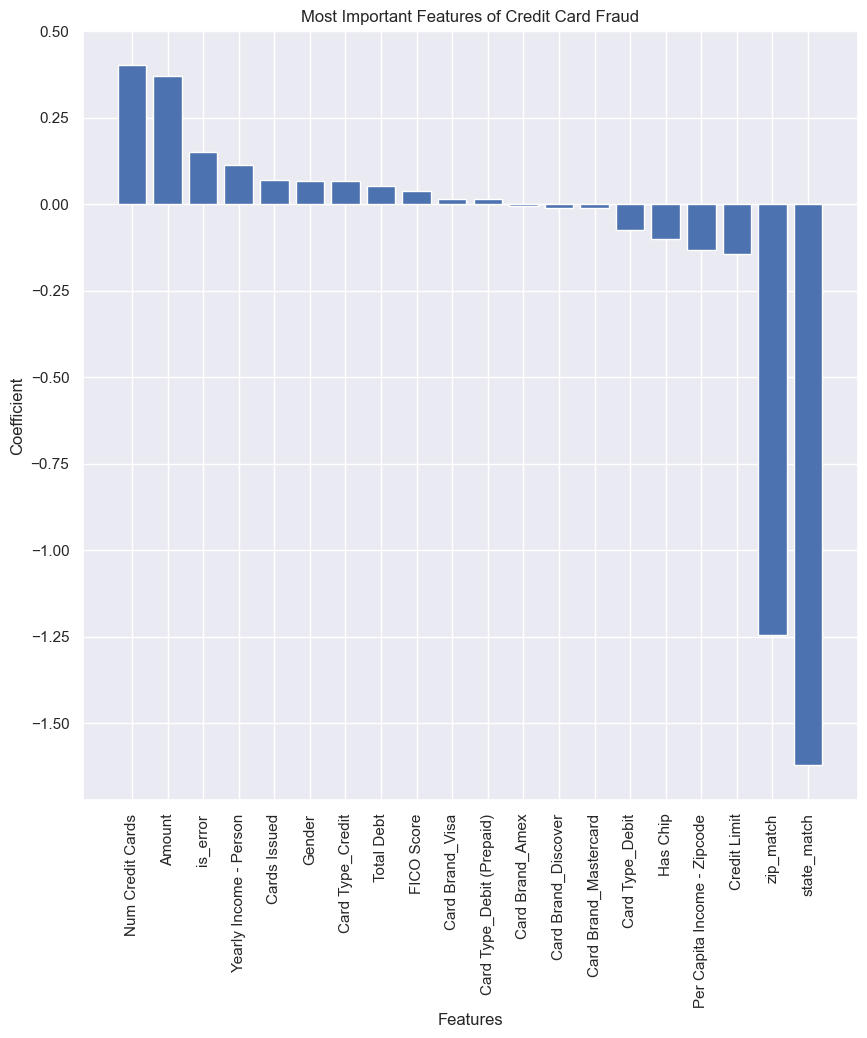

In [111]:
plt.figure(figsize=(10,10))

plt.bar(importance.sort_values(by='Importance', ascending=False)['Variable'],
                           importance.sort_values(by='Importance', ascending=False)['Importance'])

plt.title('Most Important Features of Credit Card Fraud')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=90)

plt.savefig('fraud_importance_chart.png')

plt.show()

In [112]:
#Nice to see the matching zipcodes and state can help identify that a transactions is not fraud, just as important!
#If you have more credit cards, you're probably more susceptible to fraud
#High FICO is likely related to number of credit cards
#Interesting that credit limit has a negative coefficient, I would think that's linearly related to # credit cards
#Yearly income and gender are probably linearly related to something like cards issued

In [113]:
#Let's plot an ROC Curve
#This visualizes how well the model performs

In [114]:
y_pred_prob = pipeline.predict_proba(X_test)[:, 1] 

In [115]:
#Calculate teh false positive and true positive rates
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

In [116]:
#Calculate the area under the ROC curve

roc_auc = roc_auc_score(y_test, y_pred_prob) 
roc_auc

0.9066025193367484

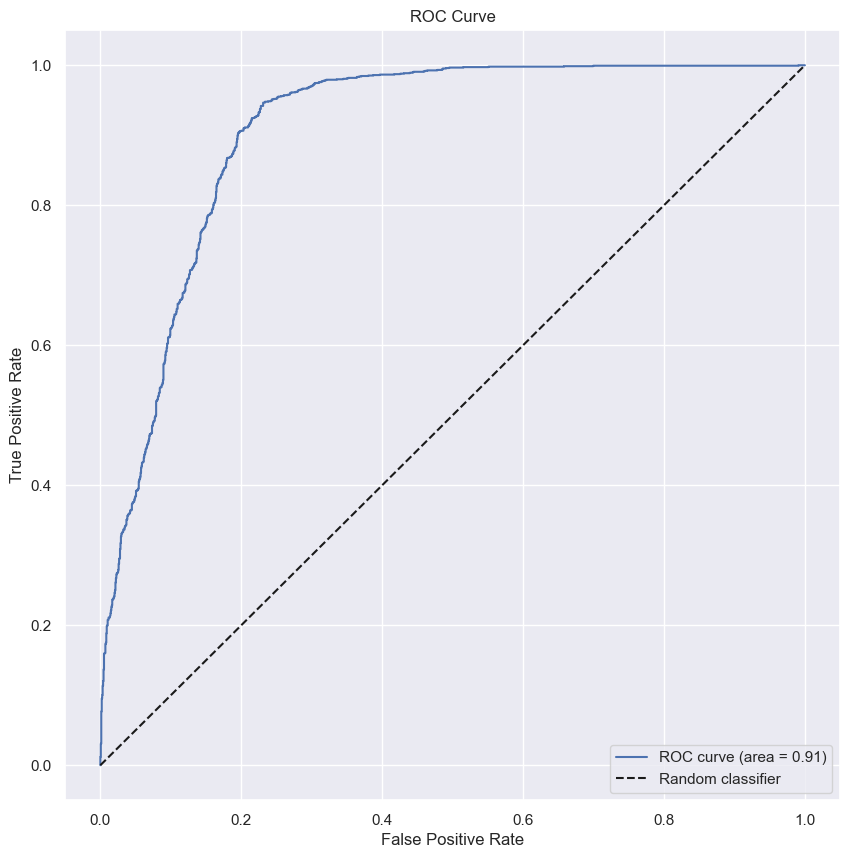

In [117]:
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc) 
# roc curve for tpr = fpr  
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve') 
plt.legend(loc="lower right")
plt.savefig('fraud_roc_curve.png')
plt.show()